<a href="https://colab.research.google.com/github/john-hafner/PHY451-Muon/blob/main/Exponential_Fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exponential Fit
The lab directions recommend using a fit of this form:

$$N(t) = N_0 e^{-\frac{t}{\tau}} + \Delta$$

$\tau$ is the mean lifetime<br>
$\Delta$ is the background count of muons that were incident but did not decay.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit

In [2]:
# TODO: Change this so instead of mounting my drive which causes a security
# prompt and can't be used by anyone else since it will mount "their" drive.
# Instead I'll simply share the data so anyone with the URL can load it, and
# then if they run the notebook it'll load my data.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Gets to base of your google drive, don't change this.
base = 'drive/My Drive'
# Specific folder the data is stored in, may be multiple levels in, separated
# by forward slashes (/)
folder = 'PHY451 - Muons/Our Data'
# file name
file = 'muon_3-14-23.data'

# Combine the above locations to the full file path.
file_path = base + '/' + folder + '/' + file
df = pd.read_csv(file_path, delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
#df = pd.read_csv(base + '/' + folder + '/' + file, delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
#df = pd.read_csv('drive/My Drive/PHY451 - Muons/Our Data/muon_3-14-23.data', delim_whitespace=True, names=['decay_time', 'timestamp'], header=None)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
print(f'Loaded {df.shape[0]} records')
print('Records of T < 20000:', df[df['decay_time'] < 20000].shape[0])
print('Records of 20000 < T < 40000:', df[(df['decay_time'] >= 20000) & (df['decay_time'] < 40000)].shape[0])
print('Records of T >= 40000:', df[df['decay_time'] >= 40000].shape[0])
df.head(5)

Loaded 8321311 records
Records of T < 20000: 17874
Records of 20000 < T < 40000: 7114368
Records of T >= 40000: 1189069


,decay_time,timestamp
0,40000,2023-02-28 16:47:15
1,40000,2023-02-28 16:47:16
2,40000,2023-02-28 16:47:17
3,40000,2023-02-28 16:47:18
4,40000,2023-02-28 16:47:19


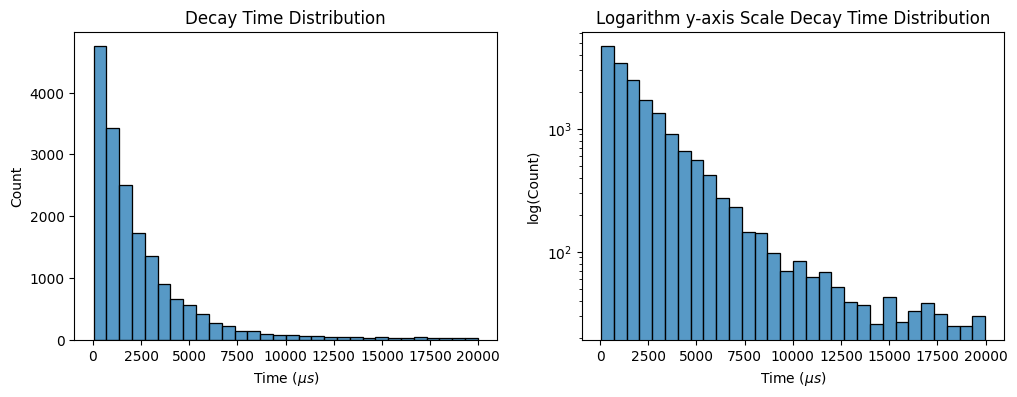

In [4]:
decay_df = df[df['decay_time'] < 20000].reset_index()

num_bins = 30

fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(data=decay_df['decay_time'], ax=ax[0], bins=num_bins)
ax[0].set_title('Decay Time Distribution')
ax[0].set_xlabel('Time $(\mu s)$')
ax[0].set_ylabel('Count')

ax[1].set_title('Logarithm y-axis Scale Decay Time Distribution')
ax[1].set_yscale('log')
ax[1].set_xlabel('Time $(\mu s)$')
ax[1].set_ylabel('log(Count)')
sns.histplot(data=decay_df['decay_time'], ax=ax[1], bins=num_bins)
plt.show()

The data is loaded, it appears to follow the expected exponential shape on the left, and a logarithm scale on the right clearly shows it turns into a linear relationship for the most part, with the extreme right being indicitive of a background noise.

A key question will be the number of bins to use.

Also we'll want to remove the time range that is less than $0.1\ \mu s$ as the lab directions recommend.  The counts there are under represented and would impact the fit.  See below, the counts of the first 100 time values are plotted on a line.  The very first value is clearly out of the pattern.

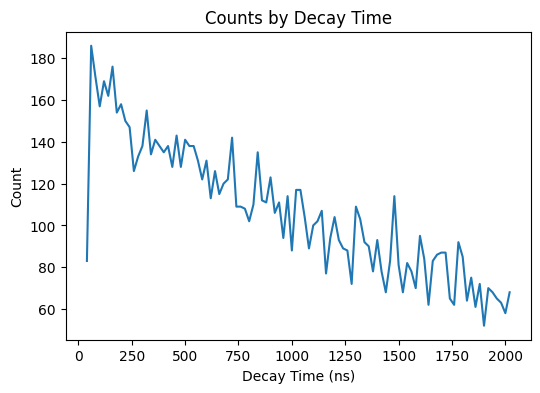

In [5]:
plt.figure(figsize=(6,4))
plt.title('Counts by Decay Time')
plt.plot(decay_df.groupby('decay_time').count().iloc[:100,0])
plt.xlabel('Decay Time (ns)')
plt.ylabel('Count')
plt.show()

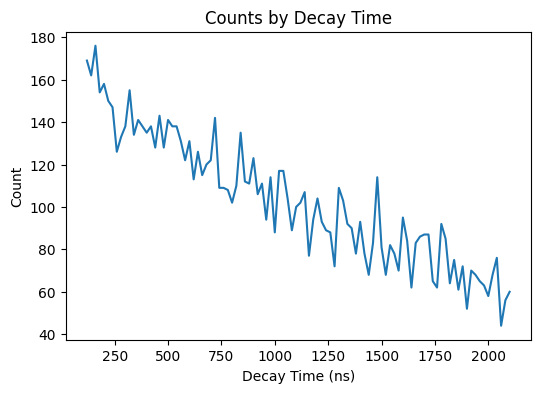

In [12]:
decay_df = decay_df.loc[decay_df['decay_time'] > 100, :]
#decay_df.head()
#decay_df.groupby('decay_time').count().sort_values(by='decay_time')
plt.figure(figsize=(6,4))
plt.title('Counts by Decay Time')
plt.plot(decay_df.groupby('decay_time').count().iloc[:100,0])
plt.xlabel('Decay Time (ns)')
plt.ylabel('Count')
plt.show()

In [14]:
decay_df['decay_time'].describe()

count    17277.000000
mean      2590.553916
std       2969.375932
min        120.000000
25%        740.000000
50%       1620.000000
75%       3260.000000
max      19980.000000
Name: decay_time, dtype: float64

The minimum value is 40 ns for the decay time.  The mean is $2.5\ \mu s$ which is promisingly close to the expected value.  But that's just a rough mean without any fitting or analysis.  And the $\sigma$ is even larger than it!  But still better than what I'd tried with the linear fit.

I'll use the curve_fit function from scipy's optimize package, where we just have to give it the general form of the function we're trying to fit, and a guess at the coefficients, and it will then attempt to find the best fit form of the function.

In [15]:
bin_df = decay_df[decay_df['decay_time'] > 100].groupby('decay_time')
bin_df.describe()

index                                                     \
            count          mean           std        min         25%   
decay_time                                                             
120         169.0  4.416414e+06  2.286861e+06   103609.0  2319922.00   
140         162.0  4.243364e+06  2.384733e+06   114992.0  2214229.75   
160         176.0  4.494529e+06  2.393100e+06   131560.0  2382611.50   
180         154.0  4.411622e+06  2.405824e+06   272067.0  2189990.50   
200         158.0  4.408085e+06  2.487723e+06    90229.0  2244379.25   
...           ...           ...           ...        ...         ...   
19820         2.0  6.688670e+06  1.494957e+06  5631576.0  6160123.00   
19860         1.0  5.249484e+06           NaN  5249484.0  5249484.00   
19880         4.0  5.108813e+06  8.044372e+05  4071092.0  4676655.50   
19940         2.0  2.347766e+06  3.185654e+06    95168.0  1221466.75   
19980         1.0  1.257576e+06           NaN  1257576.0  1257576.00   

                                              
                  50%         75%        max  
decay_time                                    
120         4638952.0  6402710.00  8312869.0  
140         4192466.5  6222280.75  8293003.0  
160         4711929.5  6425559.25  8269302.0  
180         4326667.0  6640213.50  8287318.0  
200         4274925.5  6921801.50  8283069.0  
...               ...         ...        ...  
19820       6688670.0  7217217.00  7745764.0  
19860       5249484.0  5249484.00  5249484.0  
19880       5280023.5  5712180.75  5804112.0  
19940       2347765.5  3474064.25  4600363.0  
19980       1257576.0  1257576.00  1257576.0  

[832 rows x 8 columns]

In [ ]:
def muon_fit(t, N_0, T, B):
  return N_0 * np.e**(-t / T) + B

popt, pcov = curve_fit(muon_fit, )

In [ ]:
decay_df['decay_time'].max()

19980